In [1]:
# import relevant libraries
import pandas as pd

df_customers = pd.read_csv("data/cleaned/clean_customers.csv")
df_geolocation = pd.read_csv("data/cleaned/clean_geolocation.csv")
df_order_items = pd.read_csv("data/cleaned/clean_order_items.csv")
df_order_payments = pd.read_csv("data/cleaned/clean_order_payments.csv")
df_order_reviews = pd.read_csv("data/cleaned/clean_reviews_translated.csv")
df_orders = pd.read_csv("data/cleaned/clean_orders.csv")
# df_products = pd.read_csv("data/cleaned/products.csv")
# df_sellers = pd.read_csv("data/cleaned/sellers.csv")
df_customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


# Data Enrichment

## The Schema

![schema](data/raw/HRhd2Y0.png)

## Customers

Since we already know that the keys in the customer database don't necessarily refer to different customers it isn't wise to look at the location information in isolation, so instead will join the customers to the orders to see data on the locations of customers based on orders

In [4]:
df_orders_customers = pd.merge(df_orders, df_customers, how="left", on="customer_id").head(20)
df_orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


<Axes: >

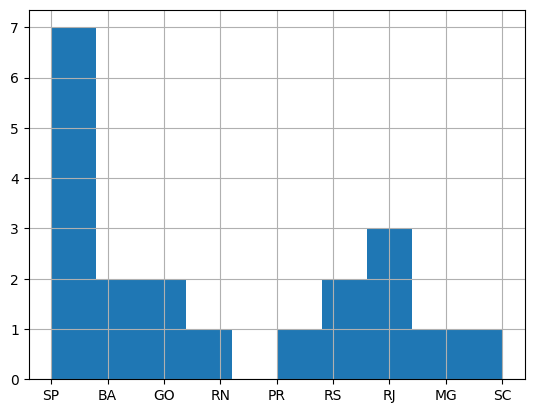

In [5]:
df_orders_customers["customer_state"].hist()

SP refers to the State of São Paulo in Brazil, the most populous state & major city, so it makes sense that the bulk of customers would reside there. 

Let us create a hypothesis that the states with higher GDP per capita have more to spend than the states with less. So will find data on the GDP per capita and chart that agains the average basket spend of customers per region, and see if there is a correlation


In [8]:
# get a list of the states that exist in our dataset for customers
customer_states = []
for state in df_orders_customers["customer_state"].unique():
  customer_states.append(state)

customer_states

['SP', 'BA', 'GO', 'RN', 'PR', 'RS', 'RJ', 'MG', 'SC']

to make sure these state names track with the states in my own data I will check them each for a city that I know is in that state. Then import a csv with their GDP per capita


In [16]:
for state in customer_states:
  print(df_orders_customers[df_orders_customers["customer_state"] == state][["customer_state","customer_city"]].max())

customer_state          SP
customer_city     sorocaba
dtype: object
customer_state                  BA
customer_city     feira de santana
dtype: object
customer_state            GO
customer_city     vianopolis
dtype: object
customer_state                         RN
customer_city     sao goncalo do amarante
dtype: object
customer_state              PR
customer_city     congonhinhas
dtype: object
customer_state            RS
customer_city     santa rosa
dtype: object
customer_state                RJ
customer_city     rio de janeiro
dtype: object
customer_state            MG
customer_city     ouro preto
dtype: object
customer_state          SC
customer_city     imbituba
dtype: object


SP is São Paulo
RJ is Rio de Janeiro
MG is Minas Gerais
BA is Bahia
SC is Santa Catarina